## Introduction

## Hypothesis

## Data Gathering

## Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
import statsmodels.api as sm
import lime
from lime import lime_tabular

In [2]:
users = pd.read_csv('AstridHe_users.csv')

## Data Cleaning

In [3]:
users.head()

,Unnamed: 0,user_id,gender,age,device,ad_1,click_1,watch_1,ad_2,click_2,...,watch_3,ad_4,click_4,watch_4,ad_5,click_5,watch_5,ad_6,click_6,watch_6
0,0,NaN,f,26,blackberry,a118,NaN,9.0,a3,NaN,...,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1.0,female,26,ios,a2,NaN,6.0,a85,NaN,...,12.0,a39,1.0,10.0,a95,1.0,11.0,a75,1.0,4.0
2,2,2.0,f,25,windows phone,a95,NaN,10.0,a26,1.0,...,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3.0,f,25,android,a6,NaN,9.0,a43,NaN,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4.0,female,27,ios,a39,NaN,7.0,a1,NaN,...,9.0,a76,NaN,8.0,a90,1.0,2.0,a26,NaN,11.0


### Incorrect information: Gender

In [4]:
# inspect gender column value
users['gender'].value_counts()

f         10096
male       5067
female     4989
m          4936
Name: gender, dtype: int64

There are different values in this column. Here, I recode the column, transforming ```f``` and ```female``` to value 1, and ```m``` and ```male``` to value 2.

In [5]:
# create a clearer variable for gender
def generate_gender(row):
    if row['gender'] == 'f':
        row['sex'] = 1
    if row['gender'] == 'female':
        row['sex'] = 1
    if row['gender'] == 'm':
        row['sex'] = 0
    if row['gender'] == 'male':
        row['sex'] = 0
    return row
users = users.apply(generate_gender, axis=1)

### New column: Condition

I want to create a new column for test condition. The values in this column shows whether the user watched six ads continuously (labeled as ```6```) or three ads (labeled as ```3```).

In [6]:
# create a variable for test condition
users['ad_4'] = users['ad_4'].fillna(0)
def generate_condition(row):
    if row['ad_4'] == 0:
        row['condition'] = 3
    else: 
        row['condition'] = 6
    return row
users = users.apply(generate_condition, axis=1)

Because in the next section, I will run regression to test the hypotheses. Here I create a dummy variable for condition **six ads**.

In [7]:
# create a dummy variable for test condition: three ads
def generate_condum(row):
    if row['ad_4'] == 0:
        row['six_ads'] = 0
    else: 
        row['six_ads'] = 1
    return row
users = users.apply(generate_condum, axis=1)

### Missing values

In [8]:
# inspect all the columns to check if there is any incorrect information
users.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,30000.0,14999.500000,8660.398374,0.0,7499.75,14999.5,22499.25,29999.0
age,30000.0,24.486233,3.002107,13.0,22.00,24.0,27.00,38.0
click_1,5221.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
click_2,5161.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
click_3,5235.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
click_4,2978.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
click_5,2962.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
click_6,2937.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
sex,25088.0,0.601283,0.489644,0.0,0.00,1.0,1.00,1.0
user_id,29999.0,15000.000000,8660.109699,1.0,7500.50,15000.0,22499.50,29999.0


Now I deal with the missing values of the six ```click``` frequency related columns. According to the frequency table, there are about 3000 - 5000 rows marked with *clicked* (```1.0```), and other rows are missing values. In order to further process the variables, here I replace missing values with 0.

In [9]:
# fill missing values in click frequency column with 0
users[['click_1', 'click_2', 'click_3', 'click_4', 'click_5', 'click_6']] = users[['click_1', 'click_2', 'click_3', 'click_4', 'click_5', 'click_6']].fillna(0)

For the ```watch``` time related columns, the minimum values are also ```1.0```, which indicate that the minimum watch time recorded is 1 second. Here, I also replace the missing values with 0, because the missing values shows that there were users watched the ads for less than 1 seconds.

In [10]:
# fill missing values in watch time column with 0
users[['watch_1', 'watch_2', 'watch_3', 'watch_4', 'watch_5', 'watch_6']] = users[['watch_1', 'watch_2', 'watch_3', 'watch_4', 'watch_5', 'watch_6']].fillna(0)

In order to test the hypotheses, I calculate the sum of the ```click``` frequency related and the ```watch``` time related columns.

In [11]:
# generate two columns for total click frequency and watch time
users['click_freq'] = users['click_1'] + users['click_2'] + users['click_3'] + users['click_4'] + users['click_5'] + users['click_6'] 
users['watch_time'] = users['watch_1'] + users['watch_2'] + users['watch_3'] + users['watch_4'] + users['watch_5'] + users['watch_6'] 

Because in the following sections, I want to compare the difference between the two conditions, and the number of ads watched by the users may influence their click frequency and total watch time. Therefore, I calculate the mean value of these two columns based on the number of ads the users watched in the test.

In [12]:
# generate two columns for average click frequency and watch time
users['mean_click'] = users['click_freq'] / users['condition']
users['mean_watch'] = users['watch_time'] / users['condition']

In order to visualize and analyze the two columns (```mean_click``` and ```mean_watch```) clearer, I round the columns.

In [13]:
# round the new columns
users[['mean_click', 'mean_watch']] = users[['mean_click', 'mean_watch']].round(decimals=2)

25088 out of 30000 users in the dataset have data in sex column. This means that there are nearly 5000 users did not indicate their gender when registered. Since the test analysis includes sex as a covariate, here I delete all rows that do not have sex data to use logistic regression in the next section.

In [14]:
# delete rows without sex data
users = users.dropna(axis=0, subset=['sex'])

For protecting users' privacy, I delete the identifiable information: ```user_id```, and other unrelated variables.

In [15]:
users.columns

Index(['Unnamed: 0', 'ad_1', 'ad_2', 'ad_3', 'ad_4', 'ad_5', 'ad_6', 'age',
       'click_1', 'click_2', 'click_3', 'click_4', 'click_5', 'click_6',
       'device', 'gender', 'sex', 'user_id', 'watch_1', 'watch_2', 'watch_3',
       'watch_4', 'watch_5', 'watch_6', 'condition', 'six_ads', 'click_freq',
       'watch_time', 'mean_click', 'mean_watch'],
      dtype='object')

In [16]:
# delete unrelated columns
users = users[['age', 'sex', 'condition', 'six_ads', 'mean_click', 'mean_watch', 'click_freq', 'watch_time']]
users.head()

,age,sex,condition,six_ads,mean_click,mean_watch,click_freq,watch_time
0,26,1.0,3,0,0.00,10.67,0.0,32.0
1,26,1.0,6,1,0.50,8.67,3.0,52.0
2,25,1.0,3,0,0.33,8.00,1.0,24.0
3,25,1.0,3,0,0.33,7.00,1.0,21.0
4,27,1.0,6,1,0.17,7.67,1.0,46.0


The data is cleaned.

## Data Exploration and Evaluation

### Descriptive information and univariate visualization

#### Demographics

In [17]:
# age
users['age'].describe()

count    25088.000000
mean        24.472178
std          3.008860
min         13.000000
25%         22.000000
50%         24.000000
75%         27.000000
max         37.000000
Name: age, dtype: float64

<AxesSubplot:xlabel='age'>

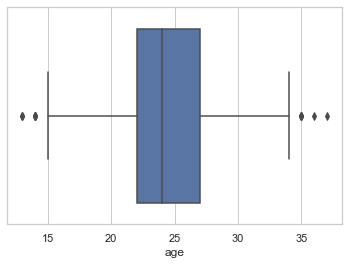

In [18]:
sns.set_theme(style="whitegrid")
sns.boxplot(x = users['age'])

The average age of the users in this dataset is 24.5 years old. The youngest participant of the user is 13 years old while the oldest is 37 years old. The majority of the participants age between 22 and 27.

In [19]:
# sex
users['sex'].value_counts()

1.0    15085
0.0    10003
Name: sex, dtype: int64

<AxesSubplot:xlabel='sex', ylabel='count'>

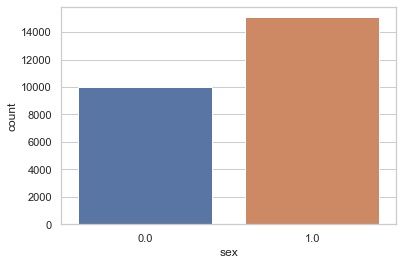

In [20]:
sns.countplot(x = users['sex'])

There are 15085 female users and 10003 male users participated in the test. The gender distribution, though not equal, is not imbalanced.

#### IV: Condition

The IV of the test indicates whether the participants watched three or six advertisements in a row.

In [21]:
# condition
users['condition'].value_counts()

3    12702
6    12386
Name: condition, dtype: int64

<AxesSubplot:xlabel='condition', ylabel='count'>

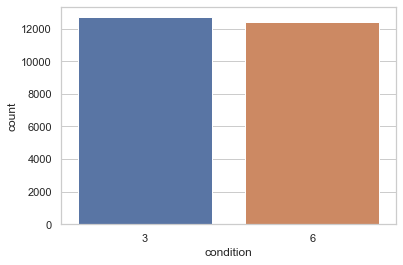

In [22]:
sns.countplot(x = users['condition'])

There were similar number of participants engaged in the two test conditions: 12702 users watched three ads and 12386 users watched six ads during the test. The two conditions of this A/B test is equally distributed.

#### DV: Click frequency and Watch time

There are two DVs in the test: 
* **Click frequency** (```click_freq```): This variable shows how many times the users clicked the advertisements during the test. For each advertisement, if the user clicked the link, the value of the according variable turns to ```1.0```.
* **Watch time** (```watch_time```): This variable indicates the time for the users to watch the ads. When an advertisement started, the time started to count, and the counting stopped when the user turned to the next video. The time was counted in seconds.

In [23]:
# click frequency - total
users['click_freq'].value_counts()

0.0    11119
1.0     8955
2.0     3737
3.0     1060
4.0      203
5.0       11
6.0        3
Name: click_freq, dtype: int64

<AxesSubplot:xlabel='click_freq', ylabel='count'>

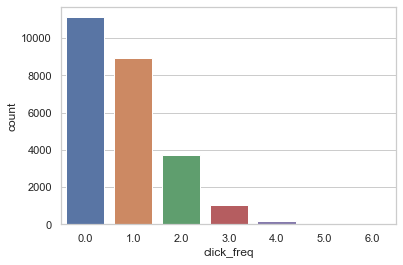

In [24]:
sns.countplot(x = users['click_freq'])

In this A/B test, when watching the continuous advertisements, over half of (55.7%) the participants clicked the ads, indicating a very high CTR (click-through rate) of the platform. This data should be used by the company as an advantage to attract advertisers.  
The majority (80%) of users either clicked no ads or clicked the ads once. 

In [25]:
# click frequency - average
users['mean_click'].value_counts()

0.00    11119
0.33     7158
0.17     4812
0.50     1026
0.67      925
1.00       37
0.83       11
Name: mean_click, dtype: int64

<AxesSubplot:xlabel='mean_click', ylabel='count'>

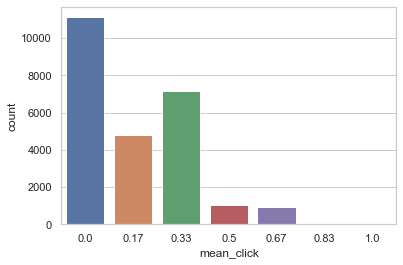

In [26]:
sns.countplot(x = users['mean_click'])

The average value shows that nearly half (47.7%) of the participants clicked 0.17 or 0.33 times into the link of the ads in the test.

In [27]:
# watch time - total
users['watch_time'].describe()

count    25088.000000
mean        41.302415
std         16.915169
min          5.000000
25%         26.000000
50%         39.000000
75%         57.000000
max         94.000000
Name: watch_time, dtype: float64

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

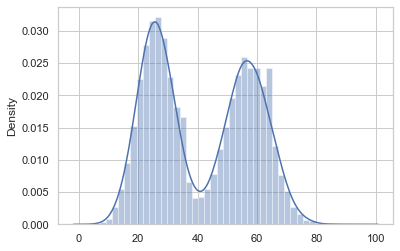

In [28]:
sns.distplot(x = users['watch_time'])

On average, the participants spent about 40 seconds on watching all ads in the test. There were users who did not care about the ads, and spent 5 seconds jumping all advertisements, and there were users nearly watched all ads from the beginning to the end. The histogram of the watch time shows that the values gather around two areas — the majority of the users spent about either 20-35 seconds or 45-63 seconds on watching advertisements. The distribution indicates that the watch time were influenced by the number of ads the users watched. Therefore, it is necessary to calculate the mean watch time of the users.

In [29]:
# watch time - average
users['mean_watch'].describe()

count    25088.000000
mean         9.076044
std          1.721457
min          1.670000
25%          8.000000
50%          9.170000
75%         10.170000
max         16.000000
Name: mean_watch, dtype: float64

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

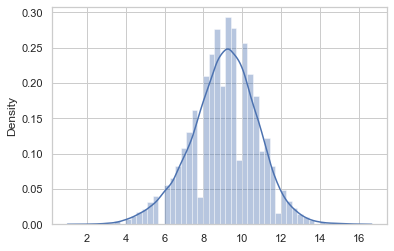

In [30]:
sns.distplot(x = users['mean_watch'])

In the test, each user spent about 9 seconds on each advertisement. Some users jumped to the next video without grabbing the meaning of the advertisement (they spent less than 2 seconds on it), while some watched the whole video. The data is also powerful to attract the advertisers, because it shows that the users watch each advertisement for a rather long time.

### Bivariate relationships

#### IV & DV: Condition + Click frequency / Watch time

In [31]:
# condition + click frequency
users.groupby('condition').agg({'mean_click':'mean'})

,mean_click
condition,
3,0.148396
6,0.199752


[Text(0, 0.5, 'Mean Click Frequency')]

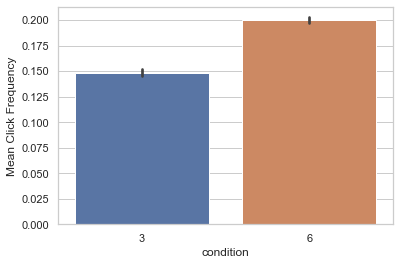

In [32]:
cond_click = sns.barplot(x = 'condition', y = 'mean_click', data = users)
cond_click.set(ylabel = 'Mean Click Frequency')

The Douyin users that watched six ads in a row in the test has, on average, higher click frequency than users watched three ads. The confidence invervals in the plot indicate that although the average click frequencies for the two groups are not high (far less than 0.5), the difference between the two groups is statisctially significant. 

In [33]:
# condition + watch time
users.groupby('condition')['mean_watch'].agg([min, max, np.mean])

,min,max,mean
condition,,,
3,1.67,16.00,8.660161
6,5.00,15.67,9.502537


[Text(0, 0.5, 'Mean Watch Time')]

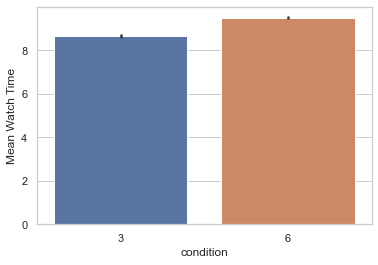

In [34]:
cond_watch = sns.barplot(x = 'condition', y = 'mean_watch', data = users)
cond_watch.set(ylabel = 'Mean Watch Time')

The users participated in the test that in the six ads condition also show longer ads watch time comparing with users in the three ads condition: they watched each advertisement for on average nearly one more second. The confidence intervals here show that the difference of the watch time between the two conditions is also statistically significant. The result indicates that, in the test, the effectiveness of the ads was influenced by the number of ads watched by the users.

#### Covariates & DV: Age / Gender + Click frequency / Watch time

[Text(0, 0.5, 'Mean Click Frequency')]

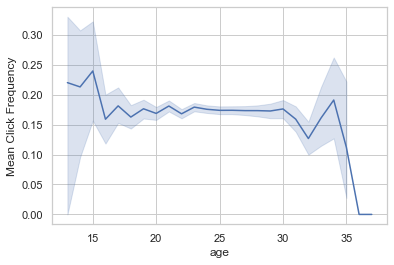

In [35]:
# age + click frequency
age_click = sns.lineplot(x = 'age', y = 'mean_click', data = users)
age_click.set(ylabel = 'Mean Click Frequency')

Users in different ages have similar frequency to click the link in an ad, while the frequency is slightly higher for users less than 15 years old and for users at about 34 years old. The confidence invertal shows that the differences for the mean click frequency are slight and not statistically significant.

[Text(0, 0.5, 'Mean Watch time')]

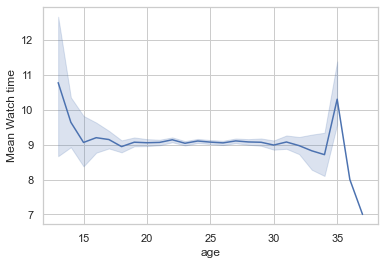

In [36]:
# age + watch time
age_watch = sns.lineplot(x = 'age', y = 'mean_watch', data = users)
age_watch.set(ylabel = 'Mean Watch time')

The watch times for users between 15 and about 34 years old are similar: the average watch time of the users is about 9 seconds. The plot shows that the users younger than 15 years old have higher watch time, but the difference is small. The users aged 35 also spent longer for each ad, and this difference is statistically significant.

In [37]:
# gender + click frequency
users.groupby('sex').agg({'mean_click':'mean'})

,mean_click
sex,
0.0,0.172824
1.0,0.174365


[Text(0.5, 0, 'Gender'), Text(0, 0.5, 'Mean Click Frequency')]

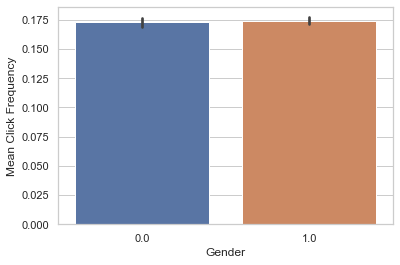

In [38]:
gender_click = sns.barplot(x = 'sex', y = 'mean_click', data = users)
gender_click.set(xlabel = 'Gender', ylabel = 'Mean Click Frequency')

The difference of click frequency caused by different gender is small. Female and male users had similar click frequency during the test.

In [39]:
# gender + watch time
users.groupby('sex')['mean_watch'].agg([min, max, np.mean])

,min,max,mean
sex,,,
0.0,2.00,16.0,9.065344
1.0,1.67,16.0,9.083138


[Text(0.5, 0, 'Gender'), Text(0, 0.5, 'Mean Watch Time')]

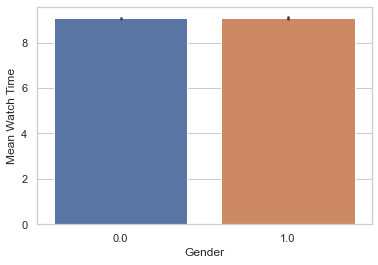

In [40]:
gender_watch = sns.barplot(x = 'sex', y = 'mean_watch', data = users)
gender_watch.set(xlabel = 'Gender', ylabel='Mean Watch Time')

The difference of watch time is also small for two gender groups. The result shows that gender has small effect on influencing the effectiveness of the advertisements on Douyin.

Overall, the dataset is balanced for users gender, age and test conditions. It can be hard for the test result to cause biases to different users, because the result would be used to distribute ads, not used to select Douyin users.

## Modelling and Hypotheses Testing

**Take 80% data!**
H1a: logit regression
H1b: linear regression

#### Regression

In [44]:
# H1a: mean click frequency
logit_click = sm.Logit(users['mean_click'], sm.add_constant(users[['six_ads', 'sex', 'age']]))
result_click = logit_click.fit()
print(result_click.summary())

Optimization terminated successfully.
         Current function value: 0.343975
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:             mean_click   No. Observations:                25088
Model:                          Logit   Df Residuals:                    25084
Method:                           MLE   Df Model:                            3
Date:                Sun, 14 Mar 2021   Pseudo R-squ.:                  -1.177
Time:                        16:27:38   Log-Likelihood:                -8629.7
converged:                       True   LL-Null:                       -3964.1
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6808      0.140    -12.041      0.000      -1.954      -1.407
six_ads        0.3594      0.

In [45]:
# H1b: mean watch time
ols_watch = sm.OLS(users['mean_watch'], sm.add_constant(users[['six_ads', 'sex', 'age']]))
result_watch = ols_watch.fit()
print(result_watch.summary())

                            OLS Regression Results                            
Dep. Variable:             mean_watch   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     532.9
Date:                Sun, 14 Mar 2021   Prob (F-statistic):               0.00
Time:                        16:27:41   Log-Likelihood:                -48450.
No. Observations:               25088   AIC:                         9.691e+04
Df Residuals:                   25084   BIC:                         9.694e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.6956      0.088     98.889      0.0

#### ML

In [46]:
# predict mean click frequency
logit_click = LogisticRegression(max_iter=1000, fit_intercept = True)
logit_click.fit(users[['six_ads', 'sex', 'age']], users['mean_click'])

ValueError: Unknown label type: 'continuous'

#### LIME